# Pass@k curves

In [52]:
from typing import Optional, TypeVar
import matplotlib.pyplot as plt
from pathlib import Path
from coderm.eval.metrics import get_pass_ks, pass_at_k, get_pass_ks_given_public, get_num_completions_per_problem, get_num_pass_public_per_problem
from coderm.utils import gunzip_json_read

from adjustText import adjust_text
import numpy as np
from math import comb
from itertools import product
import os

def calcEstVar(n, k, c):
    p = c / n
    var = 0
    for i in range(n+1):
        var += comb(n-i, k) * p**i / comb(n, k) * (comb(n-k, i) * (1-p)**(n-i))
    return var - (1-p)**(2*k)

def convert_basic_prompting(method: str):
    # if method == "basic_prompting":
    #     return "default"
    return method

T = TypeVar('T')
def split_dict_by_datasets(d: dict[tuple[str, str, str], T]) -> dict[tuple[str, str], T]:
    output_dict = {}
    for k, v in d.items():
        if k[0] not in output_dict:
            output_dict[k[0]] = {}
        output_dict[k[0]][k[1:]] = v
    return output_dict

def calc_pass_k(ns, cs, k):
    pass_ks = []
    for n, c in zip(ns, cs):
        pass_ks.append(pass_at_k(n, c, k))
    return pass_ks

def count_ns(items, is_public: bool = False) -> list[int]:
    if not is_public:
        return [len(item["results"]) for item in items]
    else:
        out = []
        for item in items:
            n = 0
            for result in item["results"]:
                if result.get("passing_public", None) is None:
                    return None
                if result["passing_public"]:
                    n += 1
            out.append(n)
        return out

def count_cs(items, is_public: bool = False) -> list[int]:
    if not is_public:
        return [sum(ex["passing"] for ex in item["results"]) for item in items]
    else:
        out = []
        for item in items:
            correct = 0
            for result in item["results"]:
                if result.get("passing_public", None) is None:
                    return None
                if result["passing"]:
                    if not result["passing_public"]:
                        print("Warning: passes private but does not pass public")
                    else:
                        correct += 1
            out.append(correct)
        return out

def calc_pass_k(ns, cs, k):
    pass_ks = []
    for n, c in zip(ns, cs):
        pass_ks.append(pass_at_k(n, c, k))
    return pass_ks

class Result():
    def __init__(self, base_directory: str, diversity_directory: Optional[str], dataset: str, method: str, model: str, temp: float = 0.9) -> None:
        self.dataset = dataset
        self.method = method
        self.model = model
        self.temp = temp
        self.path = os.path.join(base_directory, dataset, convert_basic_prompting(method) + "_" + model + f"_temp{self.temp}")
        if diversity_directory is None:
            self.diversity_path = None
        else:
            self.diversity_path = os.path.join(diversity_directory, dataset, convert_basic_prompting(method) + "_" + model + f"_temp{self.temp}", "results.npy")

        self.pass_ks = None
        self.pass_ks_given_public = None
        self.num_pass_public = None
        self.stds = None
        self.diversities = None

    def pass_k_exists(self) -> bool:
        return Path(self.path).exists()
    def diversity_exists(self) -> bool:
        if self.diversity_path is not None:
            return Path(self.diversity_path).exists()
        return False
   
    def _load_pass_k_results(self):
        if self.pass_ks is not None:
            return

        items = gunzip_json_read(self.path)["items"]
        ns = count_ns(items)
        cs = count_cs(items)
        upper_k = max(len(item["results"]) for item in items)
        pass_ks = []
        for k in range(1, upper_k+1):
            pass_ks.append(np.mean(calc_pass_k(ns, cs, k)))
        self.pass_ks = np.array(pass_ks)
 
        # vars = []
        # for item in items:
        #     single_problem = []
        #     for k in range(1, upper_k+1):
        #         single_problem.append(calcEstVar(len(items[0]["results"]), k, sum(i["passing"] for i in item["results"])))
        #     vars.append(single_problem)
        # vars = np.array(vars)
        # self.stds = np.sqrt(np.sum(vars, axis=0) / len(items) ** 2) * 2.5
    
    def _load_pass_k_public_results(self):
        assert self.pass_k_exists()
        items = gunzip_json_read(self.path)["items"]
        upper_k = max(len(item["results"]) for item in items)
        ns = count_ns(items, is_public=True)
        cs = count_cs(items, is_public=True)

        pass_ks_gp = []
        for k in range(1, upper_k+1):
            assert (ns is not None) and (cs is not None)
            public_ks = calc_pass_k(ns, cs, k)
            # public_ks = get_pass_ks_given_public(items, k)
            assert public_ks is not None
            pass_ks_gp.append(np.mean(public_ks))

        self.pass_ks_given_public = np.array(pass_ks_gp)
        self.num_pass_public = np.array(cs)
   
    def _load_diversity_results(self):
        assert self.diversity_exists()
        self.diversities = np.load(self.diversity_path)

    def get_diversities(self) -> np.ndarray:
        if self.diversities is None:
            self._load_diversity_results()
        return self.diversities

    def get_pass_ks(self) -> np.ndarray:
        if self.pass_ks is None:
            self._load_pass_k_results()
        return self.pass_ks
    
    def get_num_pass_public(self) -> Optional[np.ndarray]:
        if self.pass_ks_given_public is None:
            self._load_pass_k_public_results()
        return self.num_pass_public

    def get_pass_ks_given_public(self) -> Optional[np.ndarray]:
        if self.pass_ks_given_public is None:
            self._load_pass_k_public_results()
        return self.pass_ks_given_public

    def get_pass_ks_stds(self) -> np.ndarray:
        if self.pass_ks is None:
            self._load_pass_k_results()
        return self.stds

class ResultSeries():
    def __init__(self, base_directory: str, diversity_directory: Optional[str], datasets: list[str], models: list[str], methods: list[str], temps: list[float] = None) -> None:
        if temps is None:
            temps = [0.9]
        self.base_directory = base_directory
        self.diversity_directory = diversity_directory

        self.big_dict = {}
        self.datasets = datasets
        self.models = models
        self.methods = methods
        self.temps = temps

        self.the_dict: dict[tuple[str, str, str], Result] = {}
        for dataset, model, method, temp in product(self.datasets, self.models, self.methods, self.temps):
            add_result = Result(self.base_directory, self.diversity_directory, dataset, method, model, temp=temp)
            if add_result.pass_k_exists():
                self.the_dict[(dataset, model, method, temp)] = add_result 
            else:
                print(f"Warning, not adding {(dataset, model, method, temp)}.")

    def add_results(self, r: list[Result]):
        for result in r:
            key = (result.dataset, result.model, result.method)
            assert key not in self.the_dict
            if not result.pass_k_exists():
                print(f"Warning, not adding {key}.")
                continue
            self.the_dict[key] = result

    def add_result_series(self, rs: "ResultSeries"):
        for k, v in rs.the_dict.items():
            assert k not in self.the_dict
            self.the_dict[k] = v

    def get_pass_ks(self, with_public: bool = False, with_temp: bool = False) -> dict[tuple[str, str, str], np.ndarray]:
        out_dict = {}
        for k, v in self.the_dict.items():
            out_dict[k] = v.get_pass_ks()
            if with_public:
                assert v.get_pass_ks_given_public() is not None
                out_dict[(k[0], k[1], "public_filtered_" + k[2], k[3])] = v.get_pass_ks_given_public()

        if not with_temp:
            no_temp = {}
            for k, v in out_dict.items():
                no_temp[(k[0], k[1], k[2])] = v
            return no_temp
        return out_dict

    def get_pass_ks_stds(self) -> dict[tuple[str, str, str], np.ndarray]:
        return {k: v.get_pass_ks_stds() for k, v in self.the_dict.items()}

    def get_num_pass_public(self) -> dict[tuple[str, str, str], np.ndarray]:
        out_dict = {}
        for k, v in self.the_dict.items():
            assert v.get_num_pass_public() is not None
            out_dict[k] = v.get_num_pass_public()
        return out_dict

    def get_diversities(self) -> dict[tuple[str, str, str], np.ndarray]:
        output_dict = {}
        for k, v in self.the_dict.items():
            if v.diversity_exists():
                output_dict[k] = v.get_diversities()
        return output_dict

DIVER_DIR = "../../other_logs/similar_logs/final_logs"
BASE_DIR = "../../final_results"

result_series = ResultSeries("../../final_results/temp_sweep/", None, 
    ["livecodebench_lite_v3"],
    ["gpt-4o-mini"],
    ["default", "simple_idea"],
    temps=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
)

In [53]:
datasets = {"mbpp_plus": "MBPP+", "human_eval_plus": "HumanEval+", "livecodebench_lite_v3": "LiveCodeBench"}
label_to_str = {"basic_prompting225": "Repeated Sampling", "simple_idea225": "IdeaSearch", "combo_observation_no": "PlanSearch", 
                "default": "Repeated Sampling", "simple_idea": "IdeaSearch"}
model_to_str = {
    "gpt-4o-mini": "GPT-4o-mini",
    "gpt-4o": "GPT-4o",
    "deepseek-coder": "DeepSeek-Coder-V2",
    "sonnet-3-5": "Sonnet-3.5",
    "baby-deepseek-b_sgl": "DeepSeek-Coder-V2-Lite-Base",
    "baby-deepseek-i_sgl": "DeepSeek-Coder-V2-Lite-Instruct",
    "llama318b_sgl": "Llama-3.1-8B-Base",
    "llama318bi_sgl": "Llama-3.1-8B-Instruct",
    "llama3170b_sgl": "Llama-3.1-70B-Base",
    "llama3170bi_sgl": "Llama-3.1-70B-Instruct"
}
color_scheme = {
    'basic_prompting225': '#4DA6FF',  # Slightly darker blue
    'simple_idea225': '#A64DFF',      # Slightly darker purple
    'combo_observation_no': '#FF704D' # Slightly darker orange
}

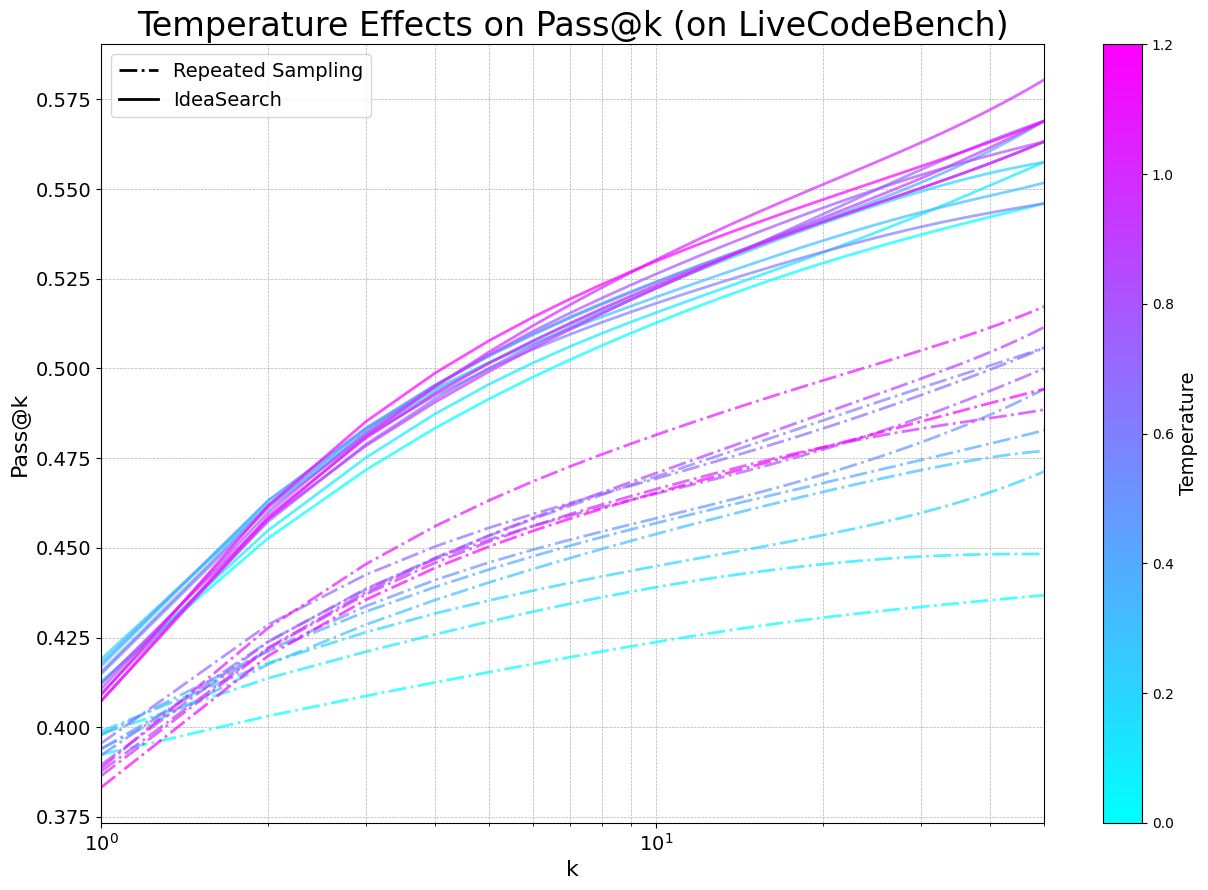

In [54]:
pks = result_series.get_pass_ks(with_temp=True)
pks = split_dict_by_datasets(split_dict_by_datasets(split_dict_by_datasets(pks)["livecodebench_lite_v3"])["gpt-4o-mini"])

import matplotlib.colors as mcolors
import matplotlib
cmap = matplotlib.colormaps.get_cmap('cool')  # Changed colormap to 'viridis' for better contrast on white background
norm = mcolors.Normalize(vmin=min(result_series.temps), vmax=max(result_series.temps))

plt.figure(figsize=(13, 9))
for method, temp_pks in pks.items():
    label = label_to_str[method]
    for temp, values in temp_pks.items():
        color = cmap(norm(temp))
        linestyle = '-.' if label == 'Repeated Sampling' else '-'
        plt.plot(np.arange(len(values))+1, values, color=color, linestyle=linestyle, linewidth=2, alpha=0.7, label=f'Temp: {temp}')

plt.xlabel('k', fontsize=16)
plt.xscale("log")
plt.ylabel('Pass@k', fontsize=16)
plt.title('Temperature Effects on Pass@k (on LiveCodeBench)', fontsize=24)
plt.xlim(1, len(values))  # Set xlim from 1 to the maximum value
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add legend for line styles
import matplotlib.lines as mlines
repeated_sampling_line = mlines.Line2D([], [], color='black', linestyle='-.', label='Repeated Sampling', linewidth=2)
idea_search_line = mlines.Line2D([], [], color='black', linestyle='-', label='IdeaSearch', linewidth=2)
plt.legend(handles=[repeated_sampling_line, idea_search_line], fontsize=14, loc='best')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Temperature', fontsize=14)

plt.tight_layout()
plt.savefig("plots/temperature_sweep0.0-1.2.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
